In [54]:
#----IMPORT LIBRAIRIES----
import pandas as pd
import numpy as np
import seaborn as sns
import json
import math
from scipy.stats import zscore

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
from plotly.subplots import make_subplots

import pvlib

import mlflow
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

import boto3

from dotenv import load_dotenv
import os

load_dotenv()
os.environ["MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING"] = "false"

import Model_func as mf
import func_cleaning as fc

In [3]:
#---VARIABLES----
weather_data_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/openweathermap/merge_openweathermap_cleaned.csv'
solar_data_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/solar/raw_solar_data.csv'
landsat_data_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/LandSat/result_EarthExplorer_region_ARA.csv'

col_solar = ['Time', 'Ap', '10cm', 'K index Planetary'] # ALWAYS include a 'Time' column (used to merge datasets)
prod_data_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/prod/eCO2mix_RTE_Auvergne-Rhone-Alpes_cleaned.csv'
target = 'tch_solaire_(%)'

cities_list = ['Moulins', 'Annecy', 'Nyons', 'Saint-Étienne', 'Aurillac']
#cities_list = ['Moulins']

# DATA COLLECTION

In [4]:
#--- Data Collection ----
full_dataset = fc.create_full_dataset(weather_data_path, solar_data_path, landsat_data_path, prod_data_path, 
                                   cities_list, col_solar, target)

df = full_dataset.copy()
print(f'df shape: {df.shape}')

# gestion des Nan
df_no_Nan = fc.handle_nan(df)

print(f'df_no_Nan shape: {df_no_Nan.shape}')

df shape: (1757, 193)
df_no_Nan shape: (1757, 124)


# DATA CLEANING

In [5]:
#---- DATA CLEANING ---
# - convert integers to floats (for calculations),
# - keep only columns of a certain type
# - remove columns containing a single unique value.

df_clean = fc.clean_dataframe(df_no_Nan, type='numeric')

print(f'df_clean shape: {df_clean.shape}')

df_clean shape: (1757, 83)


### OUTLIERS

Détection des outliers dans les variables avec 3 méthodes différentes : Z-score, interquartile range (iqr) et quantiles.

In [6]:
outliers = fc.detect_outliers(df_clean, z_thresh=3, iqr_factor=1.5, quantile_bounds=(0.05, 0.95))
outliers.sort_values('outliers_z', ascending=False)


,outliers_z,outliers_iqr,outliers_quantile
Saint-Étienne_wind_speed,34,63,134
Annecy_wind_speed,34,63,147
Aurillac_wind_speed,26,63,170
Moulins_wind_speed,20,45,174
Aurillac_pressure,18,65,149
...,...,...,...
Nyons_apparent_elevation,0,0,176
Nyons_equation_of_time,0,0,176
Nyons_azimuth,0,0,176
Nyons_elevation,0,0,176


In [7]:
print(f' nombre de colonnes ayant des outliers z_score: {(outliers['outliers_z']!=0).sum()}')
print(f' nombre de colonnes ayant des outliers iqr: {(outliers['outliers_iqr']!=0).sum()}')
print(f' nombre de colonnes ayant des outliers quantile : {(outliers['outliers_quantile']!=0).sum()}')

 nombre de colonnes ayant des outliers z_score: 16
 nombre de colonnes ayant des outliers iqr: 18
 nombre de colonnes ayant des outliers quantile : 73


In [8]:
outliers.loc['10cm']

outliers_z            12
outliers_iqr          22
outliers_quantile    145
Name: 10cm, dtype: int64

L'utilisation des quantiles supprimerait trop de données.
La méthode iqr est la plus générique, c'est donc celle qui est choisie, mais le choix entre iqr et z-score (meilleur sur distributions normales) pourrait être appronfondi (étude des distributions).

In [9]:
cols_with_outliers_iqr = fc.get_columns_with_outliers(df_clean, method="iqr")
cols_with_outliers_z = fc.get_columns_with_outliers(df_clean, method="z")

set1 = set(cols_with_outliers_iqr)
set2 = set(cols_with_outliers_z)

# Éléments communs
common = set1 & set2

# Dans list1 mais pas list2
only_in_list1 = set1 - set2

# Dans list2 mais pas list1
only_in_list2 = set2 - set1

print(f'communs : {common}')
print(f'iqr only: {only_in_list1}')
print(f'z_ only: {only_in_list2}')

communs : {'Moulins_wind_speed', 'Aurillac_dew_point', 'tch_solaire_(%)', 'Aurillac_wind_speed', 'Moulins_humidity', 'Annecy_pressure', '10cm', 'Annecy_wind_speed', 'Saint-Étienne_wind_speed', 'Aurillac_humidity', 'Nyons_wind_speed', 'K index Planetary', 'Saint-Étienne_pressure', 'Nyons_pressure', 'Moulins_pressure', 'Aurillac_pressure'}
iqr only: {'Moulins_feels_like', 'Nyons_humidity'}
z_ only: set()


In [10]:
#courbes des variables qui ont des outliers selon la méthode iqr
n_cols = 3
n_rows = math.ceil(len(cols_with_outliers_iqr) / n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=cols_with_outliers_iqr
)

row = 1
col = 1

for c in cols_with_outliers_iqr:
    fig.add_trace(
        go.Histogram(x=df[c]),
        row=row,
        col=col
    )
    col += 1
    if col > n_cols:
        col = 1
        row += 1

fig.update_layout(height=300 * n_rows, width=1000, showlegend=False)
fig.show()


In [11]:
# ----- remove outliers with iqr method
df_no_outliers_iqr = fc.remove_outliers(df_clean, target, method='iqr')
print(f'df_no-outliers_iqr shape: {df_no_outliers_iqr.shape}')

df_no_outliers_z = fc.remove_outliers(df_clean, target, method='z')
print(f'df_no-outliers_z shape: {df_no_outliers_z.shape}')

df_no_outliers_quantile = fc.remove_outliers(df_clean, target, method='quantile')
print(f'df_no-outliers_quantile shape: {df_no_outliers_quantile.shape}')

df_no-outliers_iqr shape: (1389, 83)
df_no-outliers_z shape: (1609, 83)
df_no-outliers_quantile shape: (256, 83)


la méthode quantile suprime effectivement trop de lignes du dataframe
--> on choisit la méthode iqr.

In [12]:
df_final = df_no_outliers_iqr.copy()

# FEATURE ENGINEERING
### Identifying and prioritizing columns for feature engineering

Pour savoir sur quelles colonnes travailler en priorité, on utilise une permutation_importance

In [13]:
#--- Features and target definition
X = df_final.drop(target, axis=1)
y = df_final[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

#entrainement du modele
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Permutation importance
result = permutation_importance(
    model, X_test, y_test,
    n_repeats=50,       # nombre de permutations
    random_state=42,
    scoring='neg_mean_absolute_error'        
)


In [45]:
X.rename(columns={'10cm': '10.7cm'}, inplace=True)


In [46]:
# Importance moyenne
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Extraire le suffixe après le premier underscore et supprimer le '_'
importance_df['suffix'] = importance_df['feature'].str.extract(r'_(\w+)$')[0]
importance_df['suffix'] = importance_df['suffix'].fillna(importance_df['feature'])
importance_df


,feature,importance_mean,importance_std,suffix
3,Moulins_humidity,1.610320,0.194218,humidity
19,Aurillac_humidity,0.786829,0.105834,humidity
67,Nyons_humidity,0.705855,0.130881,humidity
51,Annecy_humidity,0.515137,0.095692,humidity
69,Nyons_clouds,0.456478,0.070470,clouds
...,...,...,...,...
66,Nyons_pressure,-0.005688,0.010756,pressure
54,Annecy_wind_speed,-0.007798,0.010460,wind_speed
39,Saint-Étienne_wind_deg,-0.009517,0.010551,wind_deg
22,Aurillac_wind_speed,-0.010987,0.012062,wind_speed


In [47]:
# Grouper par suffixe
grouped = importance_df.groupby('suffix').agg(
    importance_mean=('importance_mean', 'mean'),
    importance_std=('importance_std', lambda x: np.sqrt(np.sum(x**2)/len(x)))
).reset_index()

grouped = grouped.sort_values(by='importance_mean', ascending=False)
grouped


,suffix,importance_mean,importance_std
12,humidity,0.768700,0.126055
0,10.7cm,0.368096,0.064528
6,clouds,0.264827,0.052944
5,azimuth,0.065147,0.027231
2,Month,0.053181,0.028852
15,wind_deg,0.028516,0.020137
1,K index Planetary,0.028242,0.026302
10,equation_of_time,0.022332,0.013703
17,zenith,0.017418,0.007861
4,apparent_zenith,0.013786,0.008485


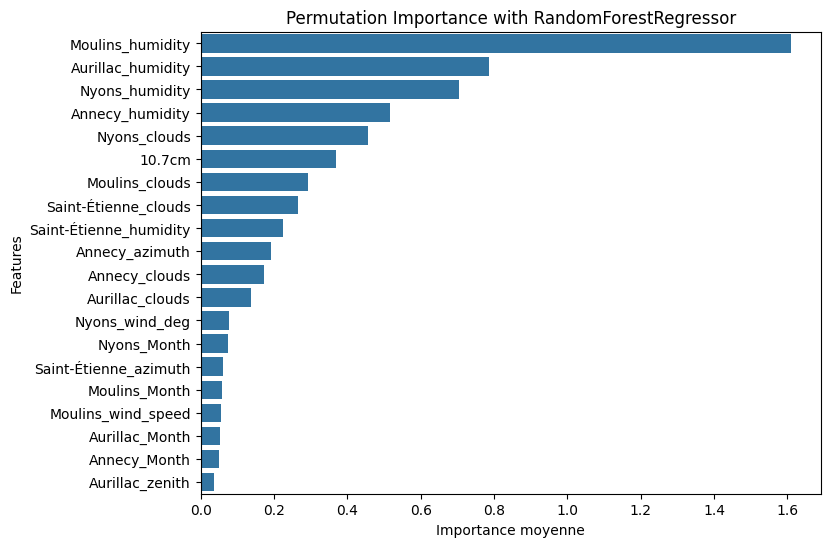

In [48]:

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df.head(20), x='importance_mean', y='feature', orient='h')
plt.title(f"Permutation Importance with RandomForestRegressor")
plt.xlabel("Importance moyenne")
plt.ylabel("Features")
plt.show()

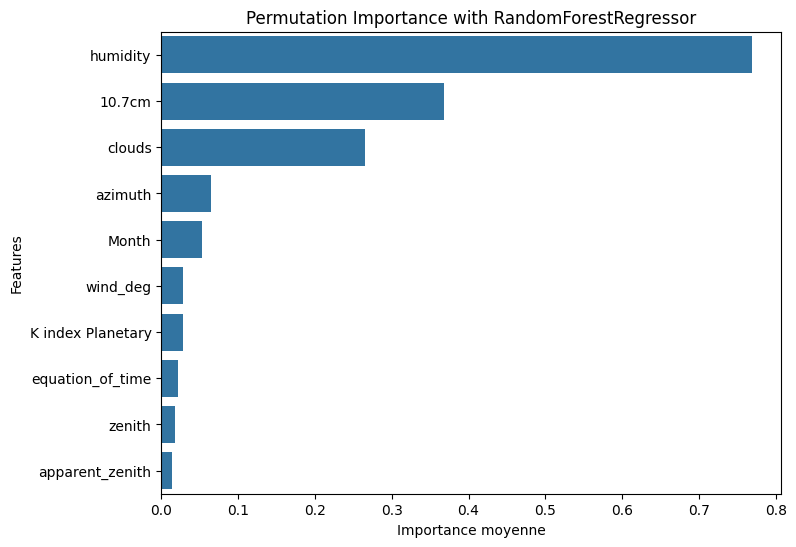

In [49]:
plt.figure(figsize=(8,6))
sns.barplot(data=grouped.head(10), x='importance_mean', y='suffix', orient='h')
plt.title(f"Permutation Importance with RandomForestRegressor")
plt.xlabel("Importance moyenne")
plt.ylabel("Features")
plt.show()

Les variables ayant le plus d'incidence sur la cible sont (dans ce contexte) :
1. humidité
2. 10cm
3. ennuagement
4. azimuth
5. mois de l'année
6. K index planetary

on travaille en priorité sur l'humidité

## travail sur les colonnes "humidité"

In [18]:
variables = [city + '_humidity' for city in cities_list]
df_humidity = df_final[variables + [target]]
df_humidity.head()

,Moulins_humidity,Annecy_humidity,Nyons_humidity,Saint-Étienne_humidity,Aurillac_humidity,tch_solaire_(%)
0,83,74,62,75,61,13.28
1,73,68,80,69,62,15.04
2,79,68,71,69,74,16.81
3,92,74,64,70,92,9.24
4,97,100,76,87,98,7.82


In [19]:
n_cols = 1
n_rows = len(variables)  # une ligne par variable
figure = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=variables
)

row = 1
col = 1

for variable in variables:
    # Crée un scatter avec trendline pour la variable courante
    f = px.scatter(df_humidity, x=variable, y=target, trendline='ols')
    
    # Ajoute toutes les traces (points + trendline) au subplot
    for trace in f.data:
        figure.add_trace(trace, row=row, col=col)
    
    # Passe à la ligne suivante si plusieurs colonnes
    row += 1

figure.update_layout(height=300 * n_rows, width=800, showlegend=False)
figure.show()


In [20]:
df_humidity.head()

,Moulins_humidity,Annecy_humidity,Nyons_humidity,Saint-Étienne_humidity,Aurillac_humidity,tch_solaire_(%)
0,83,74,62,75,61,13.28
1,73,68,80,69,62,15.04
2,79,68,71,69,74,16.81
3,92,74,64,70,92,9.24
4,97,100,76,87,98,7.82


In [21]:
variables

['Moulins_humidity',
 'Annecy_humidity',
 'Nyons_humidity',
 'Saint-Étienne_humidity',
 'Aurillac_humidity']

Moulins_humidity


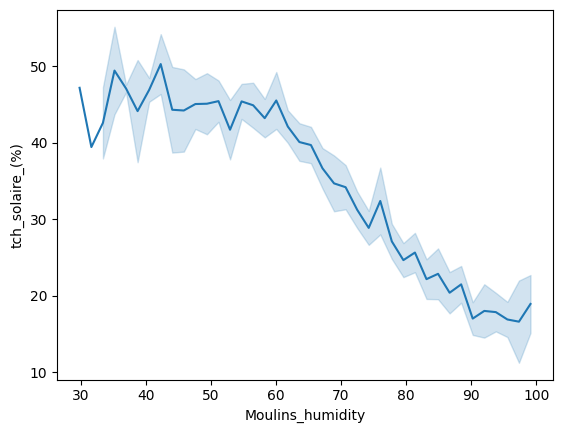

Annecy_humidity


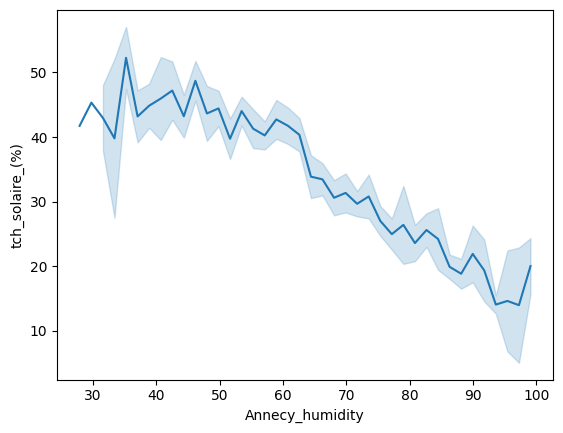

Nyons_humidity


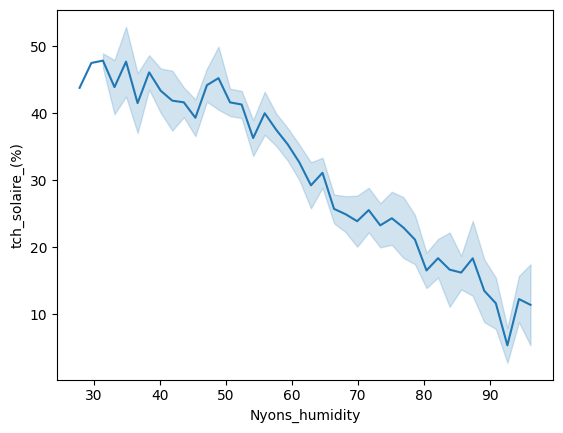

Saint-Étienne_humidity


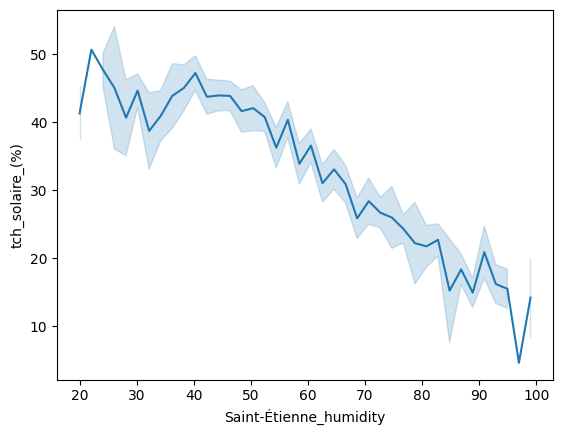

Aurillac_humidity


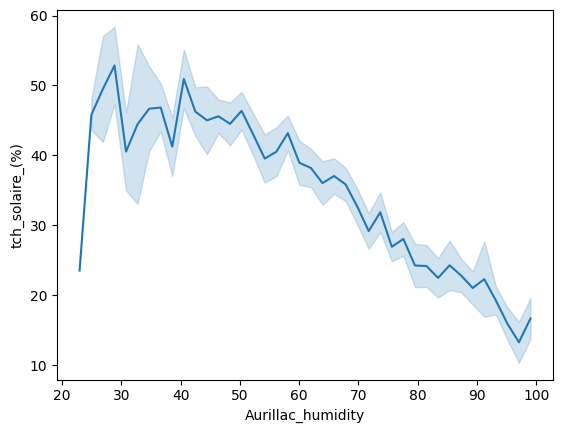

In [22]:
bins = {'Moulins_humidity':40, 'Annecy_humidity':40, 'Nyons_humidity':40,
        'Saint-Étienne_humidity':40, 'Aurillac_humidity':40}

quantized_df_humidity = pd.DataFrame()
quantized_df_humidity[target] = df_humidity[target]

for col in variables:
    print(col)
    # Calcul des intervalles avec pd.cut
    cut_result = pd.cut(df_humidity[col], bins=bins[col], retbins=True)
    bins_edges = cut_result[1]  # récupère les bornes des bins

    # Créer les labels = médiane de chaque intervalle
    labels = [(bins_edges[i] + bins_edges[i+1])/2 for i in range(len(bins_edges)-1)]

    # Appliquer pd.cut avec labels
    quantized_df_humidity[col] = pd.cut(df_humidity[col], bins=bins[col], labels=labels)
    

    plt.figure()
    sns.lineplot(quantized_df_humidity, x=col, y=target, errorbar=('se',1.68))
    plt.show()


le lien entre l'humidité et la cible semble linéaire, ce qui confirme le choix d'une régression linéaire.
Toutefois, il semble que la pente pour les faibles valeurs d'humidité ne soit pas aussi forte que celle pour les valeurs d'humidité élevées.
On va donc diviser les colonnes en deux parties 'low' and 'high', en fonction d'un seuil (seuil identique pour toutes les colonnes humidité). On teste seuil = 30, 40, 50, 60 (--> il devrait être possible de placer le seuil en hyperparamètre et d'utiliser un searchgridCV. Mais pour le moment, fait manuellement.)
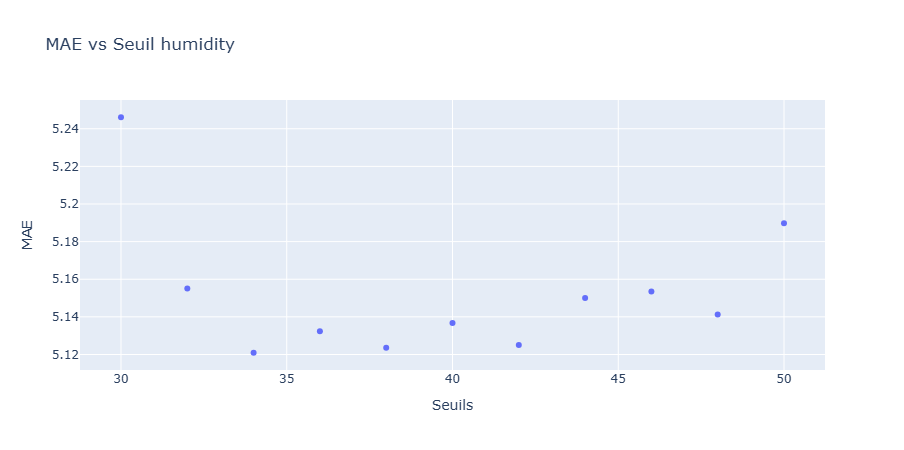

on choisit seuil_humidité = 42


## travail sur la colonne "10.7cm"

In [50]:
px.scatter(df_final, x="10cm", y=target, trendline='ols')

In [51]:
px.histogram(df_final, x="10cm")

10cm


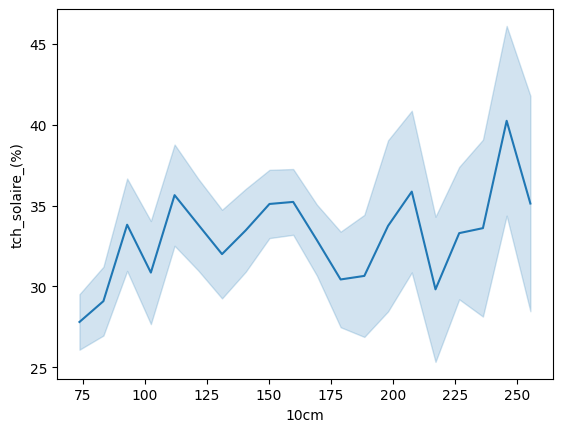

In [75]:
variables = ['10cm']
bins = {'10cm':20}

quantized_df_10cm = pd.DataFrame()
quantized_df_10cm[target] = df_final[target]

for col in variables:
    print(col)
    # Calcul des intervalles avec pd.cut
    cut_result = pd.cut(df_final[col], bins=bins[col], retbins=True)
    bins_edges = cut_result[1]  # récupère les bornes des bins

    # Créer les labels = médiane de chaque intervalle
    labels = [(bins_edges[i] + bins_edges[i+1])/2 for i in range(len(bins_edges)-1)]

    # Appliquer pd.cut avec labels
    quantized_df_10cm[col] = pd.cut(df_final[col], bins=bins[col], labels=labels)
    
    plt.figure()
    sns.lineplot(quantized_df_10cm, x=col, y=target, errorbar=('se',1.68))
    plt.show()

In [71]:
X = df_final[['10cm']]
y = df_final[target]

poly = PolynomialFeatures(degree=4, include_bias=True)
X_poly = poly.fit_transform(X)

# Récupérer un DataFrame propre
feature_names = poly.get_feature_names_out(["10cm"])
df_poly = pd.DataFrame(X_poly, columns=feature_names)

df_poly

,1,10cm,10cm^2,10cm^3,10cm^4
0,1.0,74.0,5476.0,405224.0,2.998658e+07
1,1.0,73.0,5329.0,389017.0,2.839824e+07
2,1.0,73.0,5329.0,389017.0,2.839824e+07
3,1.0,73.0,5329.0,389017.0,2.839824e+07
4,1.0,73.0,5329.0,389017.0,2.839824e+07
...,...,...,...,...,...
1384,1.0,166.0,27556.0,4574296.0,7.593331e+08
1385,1.0,172.0,29584.0,5088448.0,8.752131e+08
1386,1.0,176.0,30976.0,5451776.0,9.595126e+08
1387,1.0,180.0,32400.0,5832000.0,1.049760e+09


In [72]:
x_train, x_test, y_train, y_test = train_test_split(df_poly, y, test_size=0.3, random_state=42)
model_10cm = LinearRegression()
model_10cm.fit(x_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [73]:
y_pred = model_10cm.predict(x_test)
# Création du DataFrame pour Plotly Express
df_plot = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Scatter plot
fig = px.scatter(
    df_plot,
    x='y_test',
    y='y_pred',
    labels={'y_test': 'Valeurs réelles tch', 'y_pred': 'Prédictions'},
    title='Prédictions vs Valeurs réelles avec PolynomialFeatures de la colonne "10cm" uniquement'
)

# Ajouter une ligne y=x pour visualiser l’idéal
fig.add_shape(
    type='line',
    x0=df_plot['y_test'].min(),
    y0=df_plot['y_test'].min(),
    x1=df_plot['y_test'].max(),
    y1=df_plot['y_test'].max(),
    line=dict(color='red', dash='dash')
)
fig.update_layout(width=1000, height=600)
fig.update_layout(
    width=800, height=400,
    margin=dict(t=50)
)

fig.show()


Conclusion de ce graph : la relation entre 10cm et la cible n'est pas polynomiale